# PtyPy QC & Ingestion — **PTYPY simulated data**
This notebook demonstrates a minimal, **repo-driven** workflow:
1. **Optionally** generate a *small synthetic dataset* (so the demo runs anywhere).
2. Ingest to a standardized HDF5 using the repo’s CLI.
3. (Optionally) choose an ROI interactively.
4. Run the **repo evaluator** to produce **Outliers**, **STXM**, **DPC‑X**, and **DPC‑Y** maps.
5. Preview outputs.

**Note:** This variant deliberately **does not include any in-notebook fallback evaluator**. It is a demonstration of how to use your workflow as shipped in the repo.


## Prerequisites
- Local clone of `beamline_ptypy_Ingest` (or set `PTYPY_INGEST_REPO`).
- The package/CLIs importable (e.g., `python -m beamline_ptypy_ingest.ingest_hdf5 --help`).
- Evaluator at `ingest/evaluate.py`.


In [ ]:
# ---- Config ----
from pathlib import Path
import os, sys

# Repo location
REPO_ROOT = Path(os.environ.get("PTYPY_INGEST_REPO", ".")).resolve()
if (REPO_ROOT / "beamline_ptypy_ingest").exists():
    sys.path.insert(0, str(REPO_ROOT))

# Demo flags
GENERATE_SYNTHETIC = True   # <- set False to use your real RAW_HDF5 below
INTERACTIVE_SCAN_ROI    = False   # <- set False to skip the click-based ROI selection  [CURRENTLY BROKEN!]


EXP = "Image_20250924_025"
RAW_HDF5 = REPO_ROOT / "data" / EXP / "Image_20250924_025_000001.nxs"

# Outputs
OUT_DIR     = REPO_ROOT / "data" / EXP
#DARK_HDF5   = REPO_ROOT / "data" / EXP / EXP + "_dark_000001.h5"
#POS_HDF5    = REPO_ROOT / "data" / EXP / EXP + ".h5"

STD_HDF5     = OUT_DIR / "standardized.h5"
QC_DIR       = OUT_DIR / "telePtychoSim/QC"

OUT_DIR.mkdir(parents=True, exist_ok=True)
QC_DIR.mkdir(parents=True, exist_ok=True)

print("REPO_ROOT =", REPO_ROOT)
print("OUT_DIR   =", OUT_DIR)

# Sanity: required tools
def _require_repo_tools():
    import importlib
    try:
        importlib.import_module('ingest.ingest_hdf5')
    except Exception as e:
        raise RuntimeError("Cannot import 'ingest.ingest_hdf5'. "
                           "Ensure the repo package is on PYTHONPATH or installed.") from e
    eval_py = REPO_ROOT / "ingest" / "evaluate.py"
    if not eval_py.exists():
        raise FileNotFoundError(f"Evaluator not found at {eval_py}")
    return eval_py

EVAL_PY = _require_repo_tools()
print("Evaluator:", EVAL_PY)

REPO_ROOT = /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest
OUT_DIR   = /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025
Evaluator: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/ingest/evaluate.py


In [116]:
import shlex, sys, subprocess

cmd = [
    sys.executable, "-m", "ingest.consolidate_hermes",
    str(EXP),
    "--dir", str(OUT_DIR),
    "--overwrite"

]
print("Running consolidator:\n".format(shlex.quote(c) for c in cmd))
subprocess.run(cmd, check=True)


# Overwrite existing outputs and use column-major (Fortran) scan ordering:
#python consolidate_nxs.py HERMES2025_ABC --overwrite --order col


Running consolidator:

Found file: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/Image_20250924_025_000001.nxs
Found file: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/Image_20250924_025_dark_000001.nxs
Found file: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/Image_20250924_025.hdf5
Found beam energy in file C: 200.0 eV
Wrote dark average to /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/Image_20250924_025_000001.nxs:/entry/dark with shape (1600, 1600)
Wrote positions to /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/Image_20250924_025_000001.nxs:/entry/pos with shape (9, 2)


CompletedProcess(args=['/Users/gvr/miniconda3/envs/ptypy_full/bin/python', '-m', 'ingest.consolidate_hermes', 'Image_20250924_025', '--dir', '/Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025', '--overwrite'], returncode=0)

In [134]:
# ---- Ingest to standardized HDF5, estimating centre of diffraction images, 
#      rejecting saturated pixels (via  CLI) ----
import subprocess, shlex, sys

ROI_NY, ROI_NX = 256, 256    # default ROI size
ROI_CY, ROI_CX = 0.5, 0.5    # default normalized centre, fraction of image size

cmd = [
    sys.executable, "-m", "ingest.ingest_hermes",
    "--input", str(RAW_HDF5),
    "--data", str("/scan/scan_data/ptycho__image"),
    "--output", str(STD_HDF5),
    "--pos", str("/entry/pos"),
    "--dark", str("/entry/dark"),
    "--energy", "/entry/energy_eV",   
    "--frames-per-pos", "1",
    "--grouping", "none",
    "--roi", f"{ROI_NY},{ROI_NX}",
    "--roi-center", f"{ROI_CY},{ROI_CX}",
    "--rotate", "0",
    "--flip", "none",
    "--sat", "65000",
    "--estimate-center",
    "--overrideDetDistance", "0.05",   # in meters
    "--overridePixelSize", "11.e-6",    # in meters
    
]
print("Running:\n", " ".join(shlex.quote(c) for c in cmd))
subprocess.run(cmd, check=True)
print("Standardised file:", STD_HDF5)


Running:
 /Users/gvr/miniconda3/envs/ptypy_full/bin/python -m ingest.ingest_hermes --input /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/Image_20250924_025_000001.nxs --data /scan/scan_data/ptycho__image --output /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/standardized_demo.h5 --pos /entry/pos --dark /entry/dark --energy /entry/energy_eV --frames-per-pos 1 --grouping none --roi 256,256 --roi-center 0.5,0.5 --rotate 0 --flip none --sat 65000 --estimate-center --overrideDetDistance 0.05 --overridePixelSize 11.e-6
Loading data from /scan/scan_data/ptycho__image
Loaded data from /scan/scan_data/ptycho__image, shape: (9, 1600, 1600)
Loaded positions from /posx_m and /posy_m, shape: (9, 2)
Positions x range: 168.443337 to 170.622956 m, y range: 3985.210934 to 3986.751997 m
Assuming positions are in mm, converting to meters
Estimated mean center (cy,cx) [pixels, pre-ROI, post-orientation]: (808.2934200740475, 803.802850


Scan positions shape: 9 x 9 (N=81)
x range (µm): 168443.33700000003 → 170622.956
y range (µm): 3985210.9340000004 → 3986751.997


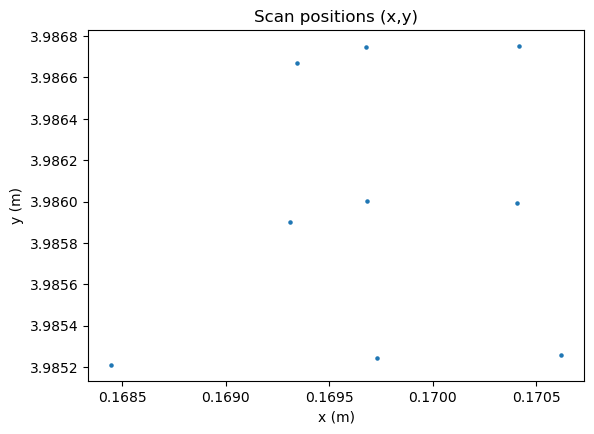

In [135]:
import h5py 

# quick check of scan dimensions in standardised file
from ingest.evaluate import read_positions
with h5py.File(STD_HDF5, "r") as h5:
    pos_x, pos_y = read_positions(h5, posx_path='/entry/pos', posy_path='/entry/pos')

print(f"\nScan positions shape: {len(pos_x)} x {len(pos_y)} (N={len(pos_x)*len(pos_y)})")
print("x range (µm):", 1.e6*pos_x.min(), "→", 1.e6*pos_x.max())
print("y range (µm):", 1.e6*pos_y.min(), "→", 1.e6*pos_y.max())

import matplotlib.pyplot as plt
plt.scatter(pos_x, pos_y, s=5); 
plt.gca().set_aspect('equal')
plt.title("Scan positions (x,y)"); plt.xlabel("x (m)"); plt.ylabel("y (m)")
plt.show()  # show scan positions


In [136]:
# ---- Run the evaluator ----
import subprocess, shlex, sys

cmd = [
    sys.executable, str(EVAL_PY), str(STD_HDF5),
    "--data-path", "/entry/data",
    "--pos-x-path", "/entry/pos",
    "--pos-y-path", "/entry/pos",
    "--roi", "128",
    "--bin", "1",
    "--embed-side", "32",
    "--pca-k", "12",
    "--w-feat", "0.5",
    "--reject-topp", "0.02",
    "--emit-ptypy-json", str(QC_DIR / "ptypy_indices.json"),
    "--out", str(QC_DIR)
]

print("Running evaluator:\n".format(shlex.quote(c) for c in cmd))
subprocess.run(cmd, check=True)
print("QC outputs written to:", QC_DIR)
print("QC outputs added to:",  STD_HDF5)

Running evaluator:

[Warning] data dtype is float32, casting to uint32
[info] data shape: (9, 256, 256), n_frames=9, n_masked=0
[info] feature deviation: median=0.8884, mad=0.1798
Outputs in: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/telePtychoSim/QC
QC outputs written to: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/telePtychoSim/QC
QC outputs added to: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/standardized_demo.h5


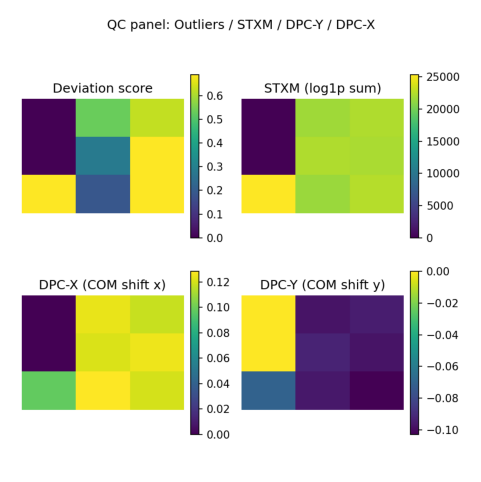

In [131]:
# ---- Preview results ----
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

panel = QC_DIR / "qc_maps.png"
if panel.exists():
    img = mpimg.imread(panel)
    plt.figure(figsize=(6,6))
    plt.imshow(img); plt.axis('off')
    plt.show()
else:
    print("qc_maps.png not found in", QC_DIR)

In [133]:
# ---- Compose a PtyPy reconstruction command ----
RECIPE = REPO_ROOT / "examples" / "ptypy_recipe_hdf5_accept.py"  # adjust if needed
ENGINE = "DM"
ITERS  = 10

USE_SUBSET = False   # True -> use subset HDF5 (Option A); False -> use JSON mask on full HDF5 (Option B)

if USE_SUBSET:
    data_path = SUBSET_HDF5
    extra = []
else:
    data_path = STD_HDF5
    # If your recipe takes a JSON accept list, provide the flag here (edit name if needed)
    #extra = ["--ptypy-indices", str(PTYPY_JSON)]

recon_cmd = [sys.executable, str(RECIPE),
             "--data", str(data_path),
             "--engine", ENGINE,
             "--iters", str(ITERS)]# + extra

print("Reconstruction command:")
print(" ".join(shlex.quote(c) for c in recon_cmd))

RUN_RECON = True  # set True to execute (requires your PtyPy env)
if RUN_RECON:
    subprocess.run(recon_cmd, check=True)

Reconstruction command:
/Users/gvr/miniconda3/envs/ptypy_full/bin/python /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/examples/ptypy_recipe_hdf5_accept.py --data /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/standardized_demo.h5 --engine DM --iters 10
[wrapper] Running original recipe:
  /Users/gvr/miniconda3/envs/ptypy_full/bin/python /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/examples/ptypy_recipe_hdf5.py --data /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/data/Image_20250924_025/standardized_demo.h5 --engine DM --iters 10
Verbosity set to 3
Data type:               single

---- Ptycho init level 1 -------------------------------------------------------
Scan will be prepared with the PtyScan subclass "Hdf5Loader"
The shape of the 
	diffraction intensities is: (9, 256, 256)
	slow axis data:(9,)
	fast axis data:(9,)
No frame filter will be applied.
Everything is wonderful, each diffraction point has a co-ordin

Traceback (most recent call last):
  File "/Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/examples/ptypy_recipe_hdf5.py", line 54, in <module>
    P = ptypy.core.Ptycho(p, level=5)
  File "/Users/gvr/code/hermes_ptypy_ingest/ptypy/ptypy/core/ptycho.py", line 388, in __init__
    self.init_data()
    ~~~~~~~~~~~~~~^^
  File "/Users/gvr/code/hermes_ptypy_ingest/ptypy/ptypy/core/ptycho.py", line 540, in init_data
    self.new_data = self.model.new_data()
                    ~~~~~~~~~~~~~~~~~~~^^
  File "/Users/gvr/code/hermes_ptypy_ingest/ptypy/ptypy/core/manager.py", line 1696, in new_data
    self.ptycho.obj.reformat(True)
    ~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/Users/gvr/code/hermes_ptypy_ingest/ptypy/ptypy/core/classes.py", line 1825, in reformat
    s.reformat()
    ~~~~~~~~~~^^
  File "/Users/gvr/code/hermes_ptypy_ingest/ptypy/ptypy/core/classes.py", line 717, in reformat
    new_data = u.crop_pad(
               ~~~~~~~~~~^
        self.data,
        ^^^^^^^^^^
     

KeyboardInterrupt: 

In [ ]:
import h5py, numpy as np, matplotlib.pyplot as plt
plt.ion()


# Quick look at the data

